# Exercise 2

Work on this before the next lecture on 12 April. We will talk about questions, comments, and solutions during the exercise after the third lecture.

Please do form study groups! When you do, make sure you can explain everything in your own words, do not simply copy&paste from others.

The solutions to a lot of these problems can probably be found with Google. Please don't. You will not learn a lot by copy&pasting from the internet.

If you want to get credit/examination on this course please upload your work to your GitHub repository for this course before the next lecture starts and post a link to your repository in [this thread](https://github.com/wildtreetech/advanced-computing-2018/issues/3). If you worked on things together with others please add their names to the notebook so we can see who formed groups.

In [1]:
# %config InlineBackend.figure_format='retina'
%matplotlib inline

import utils
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
# plt.rcParams["figure.figsize"] = (8, 8)
# plt.rcParams["font.size"] = 14
from sklearn.utils import check_random_state
import numpy as np
import sklearn.tree as skt
from importlib import reload
import copy as cp

from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection as ms
from sklearn import metrics as skm
from sklearn import preprocessing

# Question 1

Build your own random forest classifier! Using the `DecisionTreeClassifier` from scikit-learn (http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) construct your own `RandomForestClassifier`.

There are two methods for adding randomisation to the tree growing process:

* grow each tree on a bootstrap sample of the data
* configure each tree to select a subset of features for each split

Try out your new `RandomForestClassifier` on the https://archive.ics.uci.edu/ml/datasets/bank+marketing dataset.

**Note:** To test your classifier it is a good idea to use a smaller dataset like the `make_blobs` from the lecture. It will run much faster and be easier to debug.

* Can you show that a forest of trees that are all the same performs like a single decision tree?
* Can you compute the correlation coefficient between scores assigned by two different trees in the forest? In order to gain from buildign a forest you want your trees to not be 100% correlated. Experiment with the different randomisation strategies to check that they work.

### RandomForestClassifier

In [2]:
class RandomForestClassifier(object):
    """RandomForestClassifier"""

    def __init__(self, n_trees, n_features=None, ptype='classification', **kwargs):
        """Initializer. 
        n_trees: number of trees in the forest
        n_features: number of random features that each tree can see
        ptype: problem type, classification or regression
        kwargs: arguments for each tree in the forest skt.DecisionTreeClassifier(**kwargs)
        """
        self.n_trees = n_trees
        self.n_features = n_features
        self.dtc = skt.DecisionTreeClassifier(**kwargs)
        self.forest = None
        self.ptype = ptype

    def fit(self, X, y):

        self.forest = []
        self.X = X
        if self.n_features is None:
            self.n_features = X.shape[1]
        self.y = y
        self.num_train_samples = X.shape[0]
        self.dim_sample = X.shape[1]
        if self.dim_sample < self.n_features:
            raise('Selected more dimensions than available')
        self.tree_dimensions = []
        
        # generate trees
        for i in range(self.n_trees):
            # random choice of dimensions
            dims = np.random.choice(
                self.dim_sample, self.n_features, replace=False)
            # store dimensions
            self.tree_dimensions.append(dims)
            # selecting random samples (bootstraping)
            idx = np.random.choice(
                self.num_train_samples, int(self.num_train_samples / 2))
            # fit the tree
            X_sample = X[idx, :][:, dims]
            y_sample = y[idx]
            self.forest.append(cp.copy(self.dtc.fit(X_sample, y_sample)))
        return self

    def predict(self, xp, mean=True):
        """Predict outcome of xp.
            If mean is not True, it will return 
            the predictions done by each tree.
        """
        num_test_samples = len(xp)
        yps = []
        # Predict for each tree in the forest
        for i in range(self.n_trees):
            xp_tree = xp[:, self.tree_dimensions[i]]
            yps.append(self.forest[i].predict(xp_tree))
        
        if mean == True:
            # Estimate final prediction
            yps = np.asarray(yps)
            if self.ptype == 'classification':
                prediction = [max(set(list(yps[:, i])), key=list(
                    yps[:, i]).count) for i in range(num_test_samples)]
            elif self.ptype == 'regression':
                prediction = np.mean(yps, axis=1)
            else:
                raise('Not valid type')
        else:
            prediction = yps
        
        return prediction

    def predict_proba(self, xp):
        """Predicts probability of outcome. Only works for classification."""
        if self.ptype != 'classification':
            raise('Only valid for classification')

        num_test_samples = len(xp)
        yps = []
        # predict outcome
        for i in range(self.n_trees):
            xp_tree = xp[:, self.tree_dimensions[i]]
            yps.append(self.forest[i].predict(xp_tree))

        yps = np.asarray(yps)

        unique = np.unique(yps)

        predicted_probs = []
        # compute probability
        for i in range(num_test_samples):
            data = yps[:, i]
            prdct_pr = [list(data).count(
                feat) / len(data) for feat in unique]

            predicted_probs.append(prdct_pr)

        return np.array(predicted_probs)


### Test on blobs data set

In [3]:
labels = ["b", "r"]
X, y = make_blobs(n_samples=400, centers=23, random_state=42)
y = np.take(labels, (y < 10))

In [4]:
test_size = 0.40
X_fit, X_test, y_fit, y_test= ms.train_test_split(X, y, test_size=test_size, random_state=1, shuffle=True)

In [5]:
rfc = RandomForestClassifier(100, n_features=2)
clf = rfc.fit(X_fit, y_fit)

In [6]:
y_pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)

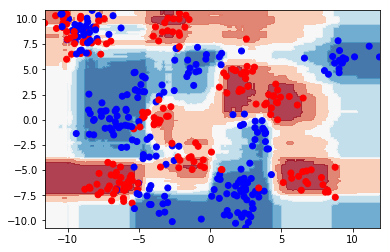

In [7]:
utils.plot_surface(clf, X, y)

## Test on bank data set

In [8]:
df = pd.read_csv('./bank/bank.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


I took only features caracterized by ordinal numbers, as the sklearn trees don't admit cathegorical data

In [9]:
data = df[['age', 'balance', 'duration','pdays','previous']]

In [10]:
data.head()

,age,balance,duration,pdays,previous
0,30,1787,79,-1,0
1,33,4789,220,339,4
2,35,1350,185,330,1
3,30,1476,199,-1,0
4,59,0,226,-1,0


I took only features caracterized by ordinal numbers, as the sklearn trees don't admit cathegorical data

In [11]:
X = data.values
y = df.y.values

In [12]:
test_size = 0.25
X_fit, X_test, y_fit, y_test= ms.train_test_split(X, y, test_size=test_size, shuffle=True)

In [13]:
clf = RandomForestClassifier(500, n_features=4)

In [14]:
clf.fit(X_fit, y_fit)

In [15]:
y_pred = np.array(clf.predict(X_test))

As the data is very unbalanced (many more 'no' than 'yes'), accuracy is not a good measure. We can use instead the ROC curve to evaluate the performance.

In [16]:
prob = clf.predict_proba(X_test)

In [17]:
prob = [p[1] for p in prob]

In [18]:
y_test_bin = np.array([0 if x == 'no' else 1 for x in y_test])

In [19]:
roc = skm.roc_curve(y_test_bin, prob)

In [20]:
skm.roc_auc_score(y_test_bin, prob)

0.87340968035889532

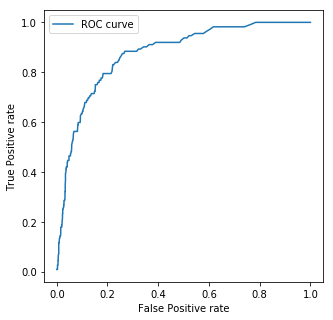

In [21]:
fig, ax = plt.subplots(figsize=(5,5))
cax = ax.plot(roc[0], roc[1], label='ROC curve')
ax.set_xlabel('False Positive rate')
ax.set_ylabel('True Positive rate')
plt.legend()
plt.show()

To include cathegorical data I tried two approaches:
    1. I used preprocessing.LabelEncoder() to convert the cardinal variables in ordinal numbers. This is bad because it creates an order that is non existing in the real data.
    
    2. I used pd.dummies to create new boolean features representing each cathegorical possibility.
    
Neither of those techniques increased significantly the accuracy (0.01 at most) of the prediction, so there is little value in adding them, and they make the algorithm much slower.

    

A third possibility that I did not try is to use hot encoding. In principle this would be the best option, although it would severly affect the performance, and it is not so quick to implement.

#### lightgbm

Finally I tried using LightGBM as in principle it allows to use cathegorical features. However I couldn't manage to improve the performance even when using the other cathegorical features not used before.

In [106]:
import lightgbm as lgb

In [107]:
df = pd.read_csv('./bank/bank.csv', sep=';')

LightGBM only accepts cathegorical data in Int format. I use here an encoder from sklearn

In [108]:
encoded = [x for x in df.columns if x not in ['age', 'balance', 'duration','pdays','previous']]

In [109]:
les = []
df_encoded = cp.copy(df)
for column in encoded:
    le = preprocessing.LabelEncoder()
    le.fit(df_encoded[column].values)
    les.append(le)
    df_encoded[column] = le.transform(df_encoded[column].values)
#     df_encoded[column] = df_encoded[column].astype('category')
# df_encoded['pdays'][df_encoded['pdays'] == -1] = 999

In [110]:
df_encoded[0:5]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,10,1,0,0,1787,0,0,0,18,10,79,0,-1,0,3,0
1,33,7,1,1,0,4789,1,1,0,10,8,220,0,339,4,0,0
2,35,4,2,2,0,1350,1,0,0,15,0,185,0,330,1,0,0
3,30,4,1,2,0,1476,1,1,2,2,6,199,3,-1,0,3,0
4,59,1,1,1,0,0,1,0,2,4,8,226,0,-1,0,3,0


In [111]:
X = df_encoded.drop(['y'], axis=1)
y = df_encoded.y.values

In [112]:
test_size = 0.25
X_fit, X_test, y_fit, y_test= ms.train_test_split(X, y, test_size=test_size, random_state=1, shuffle=True)

These are the cathegorical features

In [113]:
categorical = [x for x in encoded if x != 'y']
print(categorical)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'campaign', 'poutcome']


In [114]:
lgb_train = lgb.Dataset(X_fit, y_fit, categorical_feature=categorical)

In [115]:
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, categorical_feature=categorical)

In [130]:
params = {
    'boosting_type': 'rf',
    'objective': 'binary',
    'max_depth': 500,
    'num_leaves': 500,
    'num_threads': 4,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
#     'verbose': 0
}

In [131]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round = 1000,
                valid_sets=lgb_train,
                categorical_feature=categorical)

[1]	training's binary_logloss: 0.313881
[2]	training's binary_logloss: 0.287802
[3]	training's binary_logloss: 0.282605
[4]	training's binary_logloss: 0.279526
[5]	training's binary_logloss: 0.277834
[6]	training's binary_logloss: 0.27607
[7]	training's binary_logloss: 0.275588
[8]	training's binary_logloss: 0.27502
[9]	training's binary_logloss: 0.274504
[10]	training's binary_logloss: 0.274218
[11]	training's binary_logloss: 0.275283
[12]	training's binary_logloss: 0.274771
[13]	training's binary_logloss: 0.274055
[14]	training's binary_logloss: 0.273696
[15]	training's binary_logloss: 0.273438
[16]	training's binary_logloss: 0.273226
[17]	training's binary_logloss: 0.27295
[18]	training's binary_logloss: 0.272838
[19]	training's binary_logloss: 0.27272
[20]	training's binary_logloss: 0.273559
[21]	training's binary_logloss: 0.273286
[22]	training's binary_logloss: 0.273028
[23]	training's binary_logloss: 0.273809
[24]	training's binary_logloss: 0.274522
[25]	training's binary_loglos

[389]	training's binary_logloss: 0.270922
[390]	training's binary_logloss: 0.27091
[391]	training's binary_logloss: 0.270904
[392]	training's binary_logloss: 0.27095
[393]	training's binary_logloss: 0.270941
[394]	training's binary_logloss: 0.27093
[395]	training's binary_logloss: 0.270975
[396]	training's binary_logloss: 0.270964
[397]	training's binary_logloss: 0.271002
[398]	training's binary_logloss: 0.27105
[399]	training's binary_logloss: 0.271041
[400]	training's binary_logloss: 0.271041
[401]	training's binary_logloss: 0.271026
[402]	training's binary_logloss: 0.27101
[403]	training's binary_logloss: 0.270999
[404]	training's binary_logloss: 0.270988
[405]	training's binary_logloss: 0.270973
[406]	training's binary_logloss: 0.270957
[407]	training's binary_logloss: 0.270951
[408]	training's binary_logloss: 0.27095
[409]	training's binary_logloss: 0.270944
[410]	training's binary_logloss: 0.270938
[411]	training's binary_logloss: 0.270932
[412]	training's binary_logloss: 0.27092

[603]	training's binary_logloss: 0.270863
[604]	training's binary_logloss: 0.270852
[605]	training's binary_logloss: 0.270847
[606]	training's binary_logloss: 0.270862
[607]	training's binary_logloss: 0.27089
[608]	training's binary_logloss: 0.270884
[609]	training's binary_logloss: 0.270879
[610]	training's binary_logloss: 0.27087
[611]	training's binary_logloss: 0.27087
[612]	training's binary_logloss: 0.270863
[613]	training's binary_logloss: 0.270856
[614]	training's binary_logloss: 0.270892
[615]	training's binary_logloss: 0.270889
[616]	training's binary_logloss: 0.27089
[617]	training's binary_logloss: 0.270892
[618]	training's binary_logloss: 0.270891
[619]	training's binary_logloss: 0.270925
[620]	training's binary_logloss: 0.270918
[621]	training's binary_logloss: 0.270911
[622]	training's binary_logloss: 0.270901
[623]	training's binary_logloss: 0.270898
[624]	training's binary_logloss: 0.270891
[625]	training's binary_logloss: 0.270887
[626]	training's binary_logloss: 0.270

[820]	training's binary_logloss: 0.270763
[821]	training's binary_logloss: 0.270756
[822]	training's binary_logloss: 0.270753
[823]	training's binary_logloss: 0.270747
[824]	training's binary_logloss: 0.27074
[825]	training's binary_logloss: 0.270734
[826]	training's binary_logloss: 0.270731
[827]	training's binary_logloss: 0.270731
[828]	training's binary_logloss: 0.270729
[829]	training's binary_logloss: 0.270727
[830]	training's binary_logloss: 0.270729
[831]	training's binary_logloss: 0.270722
[832]	training's binary_logloss: 0.270714
[833]	training's binary_logloss: 0.270711
[834]	training's binary_logloss: 0.270708
[835]	training's binary_logloss: 0.270706
[836]	training's binary_logloss: 0.2707
[837]	training's binary_logloss: 0.270698
[838]	training's binary_logloss: 0.270696
[839]	training's binary_logloss: 0.27069
[840]	training's binary_logloss: 0.270688
[841]	training's binary_logloss: 0.270686
[842]	training's binary_logloss: 0.270682
[843]	training's binary_logloss: 0.270

In [132]:
res = gbm.predict(lgb_eval.data,  num_iteration=gbm.best_iteration)
result = np.array([round(x) for x in res])

In [133]:
roc = skm.roc_curve(y_test, res)

In [134]:
skm.roc_auc_score(y_test, res)

0.86072025140851061

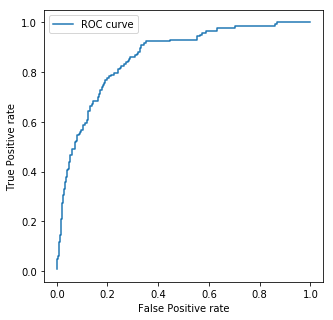

In [135]:
fig, ax = plt.subplots(figsize=(5,5))
cax = ax.plot(roc[0], roc[1], label='ROC curve')
ax.set_xlabel('False Positive rate')
ax.set_ylabel('True Positive rate')
plt.legend()
plt.show()

Maybe it is not surprising that I don't get an improved performance if one looks at the following plot, which indicates which are the most relevant features. It can be seen that the most relevant features where actually the ones that were not cathegorical. There is also the possibility that I didn't use LightGBM properly and I am missing something.

In [136]:
labels = np.array(X.columns)
labels[[0,5,11]]

array(['age', 'balance', 'duration'], dtype=object)

<Container object of 16 artists>

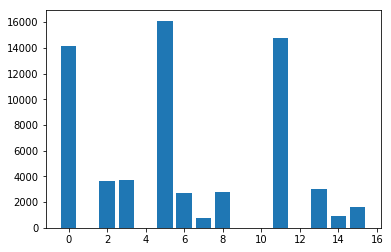

In [137]:
plt.bar(np.arange(len(gbm.feature_importance())), gbm.feature_importance())

##### Correlation

To check the correlation between two trees we can compare their predictions. To do that we can use the correletion coefficient. Although it is not meaningful for binary variables, it can give an idea of how close the predictions of 2 trees are.

In [40]:
df = pd.read_csv('./bank/bank.csv', sep=';')

In [41]:
data = df[['age', 'balance', 'duration','pdays','previous']]

In [42]:
X = data.values
y = df.y.values

In [43]:
test_size = 0.25
X_fit, X_test, y_fit, y_test= ms.train_test_split(X, y, test_size=test_size, shuffle=True)

In [44]:
clf = RandomForestClassifier(500, n_features=4)

In [45]:
clf.fit(X_fit, y_fit)

In [46]:
predictions = np.asarray(clf.predict(X_test, mean=False))
num_trees = len(predictions)

In [47]:
predictions[predictions == 'yes'] = 1
predictions[predictions == 'no'] = 0

In [48]:
predictions = np.vectorize(np.int)(predictions)

In [49]:
corrmat = np.corrcoef(predictions)

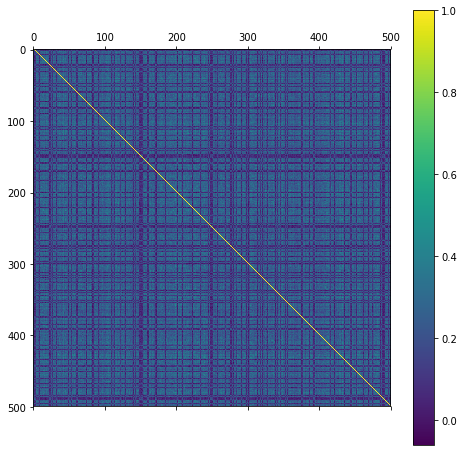

In [50]:
fig, ax = plt.subplots(figsize=(8,8))
cax = ax.matshow(corrmat, vmax=1)
fig.colorbar(cax)
plt.show()

# Question 2

Use the ready made `RandomForestClassifier` from scikit-learn to create the best model you can for the Bank Marketing dataset. Use `GridSearchCV` (or any other method) to tune your model and possible pre-processing steps. Make sure you have a test set to use after you are done tuning to estimate your generalisation error.

In [51]:
import sklearn.ensemble as ske
import sklearn.model_selection as ms
import sklearn.metrics as metrics

In [52]:
df = pd.read_csv('./bank/bank.csv', sep=';')

In [53]:
data = df[['age', 'balance', 'duration','pdays','previous']]

I took only features caracterized by ordinal numbers, as the sklearn trees don't admit cathegorical data

In [54]:
X = data
y = df.y.values

In [55]:
test_size = 0.25
X_fit, X_test, y_fit, y_test= ms.train_test_split(X, y, test_size=test_size, shuffle=True)

In [56]:
clf = ske.RandomForestClassifier(n_estimators=500,n_jobs = 2,criterion='entropy')

In [57]:
param_grid = {'max_depth':[20,30], 'criterion': ['entropy', 'gini'], 'min_impurity_decrease':[0,0.1]}
gscv = ms.GridSearchCV(clf, param_grid=param_grid, scoring=metrics.make_scorer(metrics.roc_auc_score))

In [58]:
y_fit_bin = np.array([0 if x == 'no' else 1 for x in y_fit])

In [59]:
# This can take up to 30 sec. I did not add more parameters to avoid making it even slower.
gscv.fit(X_fit, y_fit_bin)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [20, 30], 'criterion': ['entropy', 'gini'], 'min_impurity_decrease': [0, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=0)

In [60]:
gscv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [61]:
y_pred = gscv.predict_proba(X_test)

In [62]:
y_test_bin = np.array([0 if x == 'no' else 1 for x in y_test])

In [63]:
metrics.roc_auc_score(y_test_bin, y_pred[:,1])

0.86267605633802813

# Question 3

Compare the feature importances calculated by a `RandomForestClassifier`, `ExtraTreesClassifier` and `GradientBoostedTreesClassifier` on the california housing dataset. You might have to tune `n_estimators` and other hyper-parameters to get good performance.

Plot each of the features as a scatter plot with the target to learn about each variable. You can also make a plot of two features and use the target as colour.

Fit a model and tune the model complexity using a training and test data set.

Explore the feature importances and partial dependences that are important to the house price.

In [64]:
from sklearn.datasets.california_housing import fetch_california_housing

cal_housing = fetch_california_housing()

# if the above doesn't work, download `cal_housing_py3.pkl` from the GitHub repository
# and adjust the path to the downloaded file which is passed to `load()`
# uncomment the following lines
#from sklearn.externals.joblib import load
#d = load('/home/username/Downloads/cal_housing_py3.pkz')
#X, y = d[:,1:], d[:,0]/100000
#X[:, 2] /= X[:, 5]
#X[:, 3] /= X[:, 5]
#X[:, 5] = X[:, 4] / X[:, 5]

# your code here

In [65]:
cal_housing.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR'])

In [66]:
df = pd.DataFrame(data=cal_housing.data, columns=cal_housing.feature_names)

In [67]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [68]:
X = df.values
y = cal_housing.target

In [69]:
test_size = 0.25
X_fit, X_test, y_fit, y_test= ms.train_test_split(X, y, test_size=test_size, shuffle=True)

#### Random Forest

In [70]:
clf = ske.RandomForestRegressor(n_estimators=500)

In [71]:
# This can also take some time. Around 2 min.
param_grid = {'max_features': [0.1, 0.2, 0.3, 0.5]}
gscv_rf = ms.GridSearchCV(clf, param_grid=param_grid)

In [72]:
gscv_rf.fit(X_fit, y_fit)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [0.1, 0.2, 0.3, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [73]:
y_pred = gscv_rf.predict(X_test)

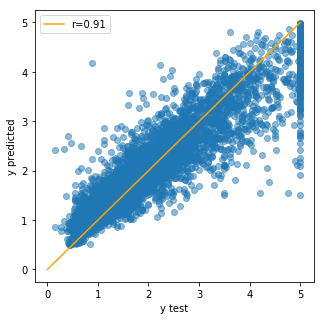

In [74]:
corrcoef = np.corrcoef(y_pred, y_test)[0,1]

fig, ax = plt.subplots(figsize=(5,5))
cax = ax.scatter(y_test, y_pred, alpha=0.5)
ax.plot([0,5],[0,5], c='orange', label='r={0:.2f}'.format(corrcoef))
ax.set_xlabel('y test')
ax.set_ylabel('y predicted')
plt.legend()
plt.show()

#### Extra Trees

In [75]:
clf = ske.ExtraTreesRegressor(n_estimators=500)

In [76]:
# This can also take some time. Around 2 min.
param_grid = {'max_features': [0.1, 0.2, 0.3, 0.5]}
gscv_xt = ms.GridSearchCV(clf, param_grid=param_grid)

In [77]:
gscv_xt.fit(X_fit, y_fit)

GridSearchCV(cv=None, error_score='raise',
       estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [0.1, 0.2, 0.3, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [78]:
gscv_xt.best_estimator_

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features=0.5, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [79]:
y_pred = gscv_xt.predict(X_test)

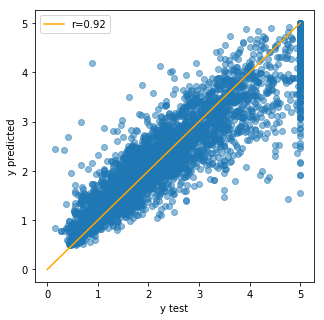

In [80]:
corrcoef = np.corrcoef(y_pred, y_test)[0,1]

fig, ax = plt.subplots(figsize=(5,5))
cax = ax.scatter(y_test, y_pred, alpha=0.5)
ax.plot([0,5],[0,5], c='orange', label='r={0:.2f}'.format(corrcoef))
ax.set_xlabel('y test')
ax.set_ylabel('y predicted')
plt.legend()
plt.show()

#### Gradient Boosted Trees Classifier

In [81]:
clf = ske.GradientBoostingRegressor(n_estimators=500, max_depth=50)

In [82]:
# This can also take some time. Around 2 min.
param_grid = {'max_features': [0.1, 0.2, 0.3, 0.5]}
gscv_gb = ms.GridSearchCV(clf, param_grid=param_grid)

In [83]:
gscv_gb.fit(X_fit, y_fit)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=50, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [0.1, 0.2, 0.3, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [84]:
gscv_gb.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=50, max_features=0.3,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [85]:
y_pred = gscv_gb.predict(X_test)

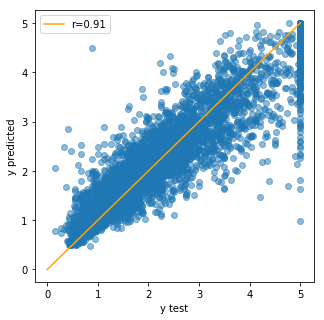

In [86]:
corrcoef = np.corrcoef(y_pred, y_test)[0,1]

fig, ax = plt.subplots(figsize=(5,5))
cax = ax.scatter(y_test, y_pred, alpha=0.5)
ax.plot([0,5],[0,5], c='orange', label='r={0:.2f}'.format(corrcoef))
ax.set_xlabel('y test')
ax.set_ylabel('y predicted')
plt.legend()
plt.show()

#### Feature Importance

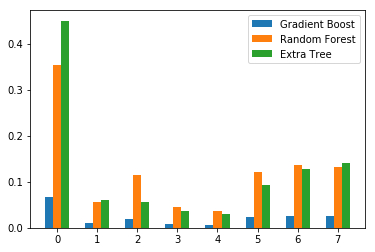

In [87]:
fig, ax = plt.subplots()
x = np.arange(8)

ax.bar(x - 0.2, gscv_gb.best_estimator_.feature_importances_, width=0.2,align='center', label='Gradient Boost')
ax.bar(x, gscv_rf.best_estimator_.feature_importances_, width=0.2,align='center', label='Random Forest')
ax.bar(x + 0.2, gscv_xt.best_estimator_.feature_importances_, width=0.2,align='center', label='Extra Tree')

ax.legend()


plt.show()

# Question 4

Competition time! Use any model you want (and understand) to make the best model you can to predict the target in the below dataset.

Each student's submission will be ranked by:
* their performance (using [AUC ROC](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) as metric) and
* how well they did at predicting their generalisation error.

Your final rank will be the average of your two ranks.

To evaluate how good you did at predicting your generalisation error Tim will release a fresh test data set after the hand-in deadline. You can then re-run your trained classifier on that data and score its performance. We will rank students by the difference between that score and their predicted score.

You can read in the data using the `pandas` library. The final column of the file contains the target (zero or one).

In [88]:
import pandas as pd

# you might have to adjust the path to the dataset
df_all = pd.read_csv("../../data/challenge-train.csv", header=None)
df_final_test = df_all[30001::]
df = df_all[0:30000]
df = df.drop([46], axis=1)

In [89]:
# convert the pandas dataframe to a numpy array
# make sure you do not include the final column
# in your training data (X) but store it as target (y)
X = df.as_matrix()[:, :-1]
y = df.as_matrix()[:, -1]

In [90]:
test_size = 0.8
X_fit, X_test, y_fit, y_test= ms.train_test_split(X, y, test_size=test_size, shuffle=True)

In [91]:
lgb_train = lgb.Dataset(X_fit, y_fit)

In [92]:
lgb_eval = lgb.Dataset(X_test, y_test)

In [93]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'max_depth': 600,
    'num_leaves': 600,
    'num_threads': 4,
    'feature_fraction': 0.2,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
#     'verbose': 0
}

In [94]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round = 20000,
                
                valid_sets=lgb_train)

[1]	training's binary_logloss: 0.636734
[2]	training's binary_logloss: 0.594818
[3]	training's binary_logloss: 0.555825
[4]	training's binary_logloss: 0.520543
[5]	training's binary_logloss: 0.499757
[6]	training's binary_logloss: 0.467004
[7]	training's binary_logloss: 0.449046
[8]	training's binary_logloss: 0.428692
[9]	training's binary_logloss: 0.40064
[10]	training's binary_logloss: 0.383571
[11]	training's binary_logloss: 0.367624
[12]	training's binary_logloss: 0.350973
[13]	training's binary_logloss: 0.335562
[14]	training's binary_logloss: 0.325692
[15]	training's binary_logloss: 0.309419
[16]	training's binary_logloss: 0.292447
[17]	training's binary_logloss: 0.278211
[18]	training's binary_logloss: 0.270361
[19]	training's binary_logloss: 0.26283
[20]	training's binary_logloss: 0.254256
[21]	training's binary_logloss: 0.245172
[22]	training's binary_logloss: 0.236276
[23]	training's binary_logloss: 0.227291
[24]	training's binary_logloss: 0.220573
[25]	training's binary_logl

[210]	training's binary_logloss: 0.00140442
[211]	training's binary_logloss: 0.00133235
[212]	training's binary_logloss: 0.00125955
[213]	training's binary_logloss: 0.0012037
[214]	training's binary_logloss: 0.0011442
[215]	training's binary_logloss: 0.00110701
[216]	training's binary_logloss: 0.0010799
[217]	training's binary_logloss: 0.00102764
[218]	training's binary_logloss: 0.000989762
[219]	training's binary_logloss: 0.000947696
[220]	training's binary_logloss: 0.000909651
[221]	training's binary_logloss: 0.000891669
[222]	training's binary_logloss: 0.000867329
[223]	training's binary_logloss: 0.000838381
[224]	training's binary_logloss: 0.00081009
[225]	training's binary_logloss: 0.000801363
[226]	training's binary_logloss: 0.000774567
[227]	training's binary_logloss: 0.000749519
[228]	training's binary_logloss: 0.00072088
[229]	training's binary_logloss: 0.000712088
[230]	training's binary_logloss: 0.00068961
[231]	training's binary_logloss: 0.000684745
[232]	training's binary_

[446]	training's binary_logloss: 0.000428631
[447]	training's binary_logloss: 0.000429557
[448]	training's binary_logloss: 0.000428751
[449]	training's binary_logloss: 0.000431187
[450]	training's binary_logloss: 0.000428883
[451]	training's binary_logloss: 0.000427021
[452]	training's binary_logloss: 0.0004321
[453]	training's binary_logloss: 0.000434934
[454]	training's binary_logloss: 0.000432405
[455]	training's binary_logloss: 0.000438273
[456]	training's binary_logloss: 0.000440642
[457]	training's binary_logloss: 0.000436525
[458]	training's binary_logloss: 0.000444461
[459]	training's binary_logloss: 0.00044408
[460]	training's binary_logloss: 0.000449452
[461]	training's binary_logloss: 0.000445603
[462]	training's binary_logloss: 0.000446844
[463]	training's binary_logloss: 0.000441352
[464]	training's binary_logloss: 0.000435019
[465]	training's binary_logloss: 0.00042994
[466]	training's binary_logloss: 0.000435429
[467]	training's binary_logloss: 0.000432419
[468]	training

[673]	training's binary_logloss: 0.00042298
[674]	training's binary_logloss: 0.000423043
[675]	training's binary_logloss: 0.000419009
[676]	training's binary_logloss: 0.000416115
[677]	training's binary_logloss: 0.000417724
[678]	training's binary_logloss: 0.000413446
[679]	training's binary_logloss: 0.00041568
[680]	training's binary_logloss: 0.000413822
[681]	training's binary_logloss: 0.000408236
[682]	training's binary_logloss: 0.000410005
[683]	training's binary_logloss: 0.000407631
[684]	training's binary_logloss: 0.000402684
[685]	training's binary_logloss: 0.000405651
[686]	training's binary_logloss: 0.000407835
[687]	training's binary_logloss: 0.000410901
[688]	training's binary_logloss: 0.000407637
[689]	training's binary_logloss: 0.000408641
[690]	training's binary_logloss: 0.000406774
[691]	training's binary_logloss: 0.000406846
[692]	training's binary_logloss: 0.000402909
[693]	training's binary_logloss: 0.000402312
[694]	training's binary_logloss: 0.000398225
[695]	traini

[971]	training's binary_logloss: 0.000488614
[972]	training's binary_logloss: 0.000490232
[973]	training's binary_logloss: 0.000486421
[974]	training's binary_logloss: 0.000485591
[975]	training's binary_logloss: 0.000482998
[976]	training's binary_logloss: 0.000484636
[977]	training's binary_logloss: 0.000482533
[978]	training's binary_logloss: 0.000481109
[979]	training's binary_logloss: 0.00048053
[980]	training's binary_logloss: 0.000482297
[981]	training's binary_logloss: 0.0004821
[982]	training's binary_logloss: 0.000483616
[983]	training's binary_logloss: 0.000481132
[984]	training's binary_logloss: 0.000480733
[985]	training's binary_logloss: 0.000477321
[986]	training's binary_logloss: 0.000480663
[987]	training's binary_logloss: 0.000478255
[988]	training's binary_logloss: 0.00047793
[989]	training's binary_logloss: 0.00047867
[990]	training's binary_logloss: 0.000476473
[991]	training's binary_logloss: 0.000472949
[992]	training's binary_logloss: 0.000475442
[993]	training'

[1254]	training's binary_logloss: 0.000451853
[1255]	training's binary_logloss: 0.000452305
[1256]	training's binary_logloss: 0.000454226
[1257]	training's binary_logloss: 0.000455348
[1258]	training's binary_logloss: 0.000453211
[1259]	training's binary_logloss: 0.000451091
[1260]	training's binary_logloss: 0.000451632
[1261]	training's binary_logloss: 0.000449113
[1262]	training's binary_logloss: 0.000445757
[1263]	training's binary_logloss: 0.000444863
[1264]	training's binary_logloss: 0.000443732
[1265]	training's binary_logloss: 0.000441796
[1266]	training's binary_logloss: 0.000444883
[1267]	training's binary_logloss: 0.00044411
[1268]	training's binary_logloss: 0.000443029
[1269]	training's binary_logloss: 0.000445361
[1270]	training's binary_logloss: 0.000446807
[1271]	training's binary_logloss: 0.000447212
[1272]	training's binary_logloss: 0.000446156
[1273]	training's binary_logloss: 0.000446919
[1274]	training's binary_logloss: 0.00044843
[1275]	training's binary_logloss: 0.

[1596]	training's binary_logloss: 0.00045184
[1597]	training's binary_logloss: 0.000449531
[1598]	training's binary_logloss: 0.000451806
[1599]	training's binary_logloss: 0.000449947
[1600]	training's binary_logloss: 0.000450994
[1601]	training's binary_logloss: 0.000450956
[1602]	training's binary_logloss: 0.000449228
[1603]	training's binary_logloss: 0.000449256
[1604]	training's binary_logloss: 0.000448456
[1605]	training's binary_logloss: 0.000450041
[1606]	training's binary_logloss: 0.000450624
[1607]	training's binary_logloss: 0.00045254
[1608]	training's binary_logloss: 0.000449799
[1609]	training's binary_logloss: 0.000449326
[1610]	training's binary_logloss: 0.00045087
[1611]	training's binary_logloss: 0.000449453
[1612]	training's binary_logloss: 0.000447152
[1613]	training's binary_logloss: 0.000449022
[1614]	training's binary_logloss: 0.000449968
[1615]	training's binary_logloss: 0.000447836
[1616]	training's binary_logloss: 0.000449136
[1617]	training's binary_logloss: 0.0

[1956]	training's binary_logloss: 1.29638e-06
[1957]	training's binary_logloss: 1.29561e-06
[1958]	training's binary_logloss: 1.29504e-06
[1959]	training's binary_logloss: 1.29432e-06
[1960]	training's binary_logloss: 1.29361e-06
[1961]	training's binary_logloss: 1.29309e-06
[1962]	training's binary_logloss: 1.2925e-06
[1963]	training's binary_logloss: 1.29178e-06
[1964]	training's binary_logloss: 1.29136e-06
[1965]	training's binary_logloss: 1.29043e-06
[1966]	training's binary_logloss: 1.29006e-06
[1967]	training's binary_logloss: 1.28941e-06
[1968]	training's binary_logloss: 1.28879e-06
[1969]	training's binary_logloss: 1.28774e-06
[1970]	training's binary_logloss: 1.28712e-06
[1971]	training's binary_logloss: 1.28663e-06
[1972]	training's binary_logloss: 1.28605e-06
[1973]	training's binary_logloss: 1.2854e-06
[1974]	training's binary_logloss: 1.28481e-06
[1975]	training's binary_logloss: 1.28425e-06
[1976]	training's binary_logloss: 1.28335e-06
[1977]	training's binary_logloss: 1.

[2281]	training's binary_logloss: 1.13131e-06
[2282]	training's binary_logloss: 1.13094e-06
[2283]	training's binary_logloss: 1.13051e-06
[2284]	training's binary_logloss: 1.1302e-06
[2285]	training's binary_logloss: 1.12985e-06
[2286]	training's binary_logloss: 1.12954e-06
[2287]	training's binary_logloss: 1.12884e-06
[2288]	training's binary_logloss: 1.12853e-06
[2289]	training's binary_logloss: 1.12829e-06
[2290]	training's binary_logloss: 1.12802e-06
[2291]	training's binary_logloss: 1.12767e-06
[2292]	training's binary_logloss: 1.12731e-06
[2293]	training's binary_logloss: 1.12719e-06
[2294]	training's binary_logloss: 1.12697e-06
[2295]	training's binary_logloss: 1.12685e-06
[2296]	training's binary_logloss: 1.12638e-06
[2297]	training's binary_logloss: 1.12606e-06
[2298]	training's binary_logloss: 1.12565e-06
[2299]	training's binary_logloss: 1.12527e-06
[2300]	training's binary_logloss: 1.12498e-06
[2301]	training's binary_logloss: 1.12475e-06
[2302]	training's binary_logloss: 1

[2583]	training's binary_logloss: 1.03766e-06
[2584]	training's binary_logloss: 1.03708e-06
[2585]	training's binary_logloss: 1.03708e-06
[2586]	training's binary_logloss: 1.03669e-06
[2587]	training's binary_logloss: 1.03641e-06
[2588]	training's binary_logloss: 1.03616e-06
[2589]	training's binary_logloss: 1.0358e-06
[2590]	training's binary_logloss: 1.03555e-06
[2591]	training's binary_logloss: 1.03509e-06
[2592]	training's binary_logloss: 1.03465e-06
[2593]	training's binary_logloss: 1.03452e-06
[2594]	training's binary_logloss: 1.03424e-06
[2595]	training's binary_logloss: 1.03396e-06
[2596]	training's binary_logloss: 1.03378e-06
[2597]	training's binary_logloss: 1.03348e-06
[2598]	training's binary_logloss: 1.03328e-06
[2599]	training's binary_logloss: 1.03298e-06
[2600]	training's binary_logloss: 1.03282e-06
[2601]	training's binary_logloss: 1.03246e-06
[2602]	training's binary_logloss: 1.03221e-06
[2603]	training's binary_logloss: 1.03208e-06
[2604]	training's binary_logloss: 1

[2903]	training's binary_logloss: 9.6774e-07
[2904]	training's binary_logloss: 9.67437e-07
[2905]	training's binary_logloss: 9.67188e-07
[2906]	training's binary_logloss: 9.66878e-07
[2907]	training's binary_logloss: 9.66601e-07
[2908]	training's binary_logloss: 9.66296e-07
[2909]	training's binary_logloss: 9.66157e-07
[2910]	training's binary_logloss: 9.65941e-07
[2911]	training's binary_logloss: 9.65621e-07
[2912]	training's binary_logloss: 9.65517e-07
[2913]	training's binary_logloss: 9.65078e-07
[2914]	training's binary_logloss: 9.64752e-07
[2915]	training's binary_logloss: 9.64636e-07
[2916]	training's binary_logloss: 9.64387e-07
[2917]	training's binary_logloss: 9.64194e-07
[2918]	training's binary_logloss: 9.63852e-07
[2919]	training's binary_logloss: 9.63617e-07
[2920]	training's binary_logloss: 9.63421e-07
[2921]	training's binary_logloss: 9.63285e-07
[2922]	training's binary_logloss: 9.63049e-07
[2923]	training's binary_logloss: 9.62909e-07
[2924]	training's binary_logloss: 9

[3225]	training's binary_logloss: 9.11931e-07
[3226]	training's binary_logloss: 9.11645e-07
[3227]	training's binary_logloss: 9.11438e-07
[3228]	training's binary_logloss: 9.11283e-07
[3229]	training's binary_logloss: 9.11148e-07
[3230]	training's binary_logloss: 9.10825e-07
[3231]	training's binary_logloss: 9.10578e-07
[3232]	training's binary_logloss: 9.10488e-07
[3233]	training's binary_logloss: 9.10421e-07
[3234]	training's binary_logloss: 9.10208e-07
[3235]	training's binary_logloss: 9.10104e-07
[3236]	training's binary_logloss: 9.09997e-07
[3237]	training's binary_logloss: 9.09976e-07
[3238]	training's binary_logloss: 9.09828e-07
[3239]	training's binary_logloss: 9.09751e-07
[3240]	training's binary_logloss: 9.09615e-07
[3241]	training's binary_logloss: 9.09499e-07
[3242]	training's binary_logloss: 9.09427e-07
[3243]	training's binary_logloss: 9.09307e-07
[3244]	training's binary_logloss: 9.09131e-07
[3245]	training's binary_logloss: 9.08917e-07
[3246]	training's binary_logloss: 

[3529]	training's binary_logloss: 8.71031e-07
[3530]	training's binary_logloss: 8.70971e-07
[3531]	training's binary_logloss: 8.70895e-07
[3532]	training's binary_logloss: 8.70674e-07
[3533]	training's binary_logloss: 8.70624e-07
[3534]	training's binary_logloss: 8.70453e-07
[3535]	training's binary_logloss: 8.70355e-07
[3536]	training's binary_logloss: 8.70223e-07
[3537]	training's binary_logloss: 8.70082e-07
[3538]	training's binary_logloss: 8.70005e-07
[3539]	training's binary_logloss: 8.69927e-07
[3540]	training's binary_logloss: 8.6991e-07
[3541]	training's binary_logloss: 8.6971e-07
[3542]	training's binary_logloss: 8.69608e-07
[3543]	training's binary_logloss: 8.69504e-07
[3544]	training's binary_logloss: 8.69341e-07
[3545]	training's binary_logloss: 8.69193e-07
[3546]	training's binary_logloss: 8.69044e-07
[3547]	training's binary_logloss: 8.68858e-07
[3548]	training's binary_logloss: 8.68756e-07
[3549]	training's binary_logloss: 8.68638e-07
[3550]	training's binary_logloss: 8.

[3843]	training's binary_logloss: 8.36613e-07
[3844]	training's binary_logloss: 8.36495e-07
[3845]	training's binary_logloss: 8.36367e-07
[3846]	training's binary_logloss: 8.36359e-07
[3847]	training's binary_logloss: 8.36306e-07
[3848]	training's binary_logloss: 8.3627e-07
[3849]	training's binary_logloss: 8.36162e-07
[3850]	training's binary_logloss: 8.36098e-07
[3851]	training's binary_logloss: 8.35903e-07
[3852]	training's binary_logloss: 8.35741e-07
[3853]	training's binary_logloss: 8.35621e-07
[3854]	training's binary_logloss: 8.35484e-07
[3855]	training's binary_logloss: 8.35459e-07
[3856]	training's binary_logloss: 8.35444e-07
[3857]	training's binary_logloss: 8.35352e-07
[3858]	training's binary_logloss: 8.35247e-07
[3859]	training's binary_logloss: 8.35115e-07
[3860]	training's binary_logloss: 8.35041e-07
[3861]	training's binary_logloss: 8.34967e-07
[3862]	training's binary_logloss: 8.34862e-07
[3863]	training's binary_logloss: 8.3477e-07
[3864]	training's binary_logloss: 8.

[4239]	training's binary_logloss: 8.00779e-07
[4240]	training's binary_logloss: 8.00659e-07
[4241]	training's binary_logloss: 8.00553e-07
[4242]	training's binary_logloss: 8.00547e-07
[4243]	training's binary_logloss: 8.0044e-07
[4244]	training's binary_logloss: 8.00261e-07
[4245]	training's binary_logloss: 8.00206e-07
[4246]	training's binary_logloss: 8.00051e-07
[4247]	training's binary_logloss: 8.00042e-07
[4248]	training's binary_logloss: 7.99998e-07
[4249]	training's binary_logloss: 7.99954e-07
[4250]	training's binary_logloss: 7.99912e-07
[4251]	training's binary_logloss: 7.99751e-07
[4252]	training's binary_logloss: 7.99609e-07
[4253]	training's binary_logloss: 7.99572e-07
[4254]	training's binary_logloss: 7.99526e-07
[4255]	training's binary_logloss: 7.99452e-07
[4256]	training's binary_logloss: 7.99379e-07
[4257]	training's binary_logloss: 7.99298e-07
[4258]	training's binary_logloss: 7.99222e-07
[4259]	training's binary_logloss: 7.99174e-07
[4260]	training's binary_logloss: 7

[4587]	training's binary_logloss: 7.72076e-07
[4588]	training's binary_logloss: 7.72018e-07
[4589]	training's binary_logloss: 7.71975e-07
[4590]	training's binary_logloss: 7.71901e-07
[4591]	training's binary_logloss: 7.71737e-07
[4592]	training's binary_logloss: 7.71694e-07
[4593]	training's binary_logloss: 7.71621e-07
[4594]	training's binary_logloss: 7.71535e-07
[4595]	training's binary_logloss: 7.71479e-07
[4596]	training's binary_logloss: 7.71436e-07
[4597]	training's binary_logloss: 7.71378e-07
[4598]	training's binary_logloss: 7.71295e-07
[4599]	training's binary_logloss: 7.71267e-07
[4600]	training's binary_logloss: 7.71244e-07
[4601]	training's binary_logloss: 7.7115e-07
[4602]	training's binary_logloss: 7.71152e-07
[4603]	training's binary_logloss: 7.7097e-07
[4604]	training's binary_logloss: 7.7098e-07
[4605]	training's binary_logloss: 7.7089e-07
[4606]	training's binary_logloss: 7.70799e-07
[4607]	training's binary_logloss: 7.70728e-07
[4608]	training's binary_logloss: 7.70

[4926]	training's binary_logloss: 7.4846e-07
[4927]	training's binary_logloss: 7.4837e-07
[4928]	training's binary_logloss: 7.48278e-07
[4929]	training's binary_logloss: 7.48235e-07
[4930]	training's binary_logloss: 7.48213e-07
[4931]	training's binary_logloss: 7.4819e-07
[4932]	training's binary_logloss: 7.48131e-07
[4933]	training's binary_logloss: 7.48083e-07
[4934]	training's binary_logloss: 7.47982e-07
[4935]	training's binary_logloss: 7.47964e-07
[4936]	training's binary_logloss: 7.47855e-07
[4937]	training's binary_logloss: 7.47778e-07
[4938]	training's binary_logloss: 7.47617e-07
[4939]	training's binary_logloss: 7.47497e-07
[4940]	training's binary_logloss: 7.47357e-07
[4941]	training's binary_logloss: 7.473e-07
[4942]	training's binary_logloss: 7.47244e-07
[4943]	training's binary_logloss: 7.47208e-07
[4944]	training's binary_logloss: 7.47183e-07
[4945]	training's binary_logloss: 7.47163e-07
[4946]	training's binary_logloss: 7.47015e-07
[4947]	training's binary_logloss: 7.468

[5252]	training's binary_logloss: 7.27273e-07
[5253]	training's binary_logloss: 7.2723e-07
[5254]	training's binary_logloss: 7.27215e-07
[5255]	training's binary_logloss: 7.27179e-07
[5256]	training's binary_logloss: 7.27183e-07
[5257]	training's binary_logloss: 7.27149e-07
[5258]	training's binary_logloss: 7.27094e-07
[5259]	training's binary_logloss: 7.27076e-07
[5260]	training's binary_logloss: 7.27061e-07
[5261]	training's binary_logloss: 7.27008e-07
[5262]	training's binary_logloss: 7.26993e-07
[5263]	training's binary_logloss: 7.26983e-07
[5264]	training's binary_logloss: 7.26931e-07
[5265]	training's binary_logloss: 7.26834e-07
[5266]	training's binary_logloss: 7.26791e-07
[5267]	training's binary_logloss: 7.26762e-07
[5268]	training's binary_logloss: 7.26659e-07
[5269]	training's binary_logloss: 7.26555e-07
[5270]	training's binary_logloss: 7.26474e-07
[5271]	training's binary_logloss: 7.26438e-07
[5272]	training's binary_logloss: 7.26376e-07
[5273]	training's binary_logloss: 7

[5585]	training's binary_logloss: 7.0944e-07
[5586]	training's binary_logloss: 7.09422e-07
[5587]	training's binary_logloss: 7.09297e-07
[5588]	training's binary_logloss: 7.0929e-07
[5589]	training's binary_logloss: 7.0918e-07
[5590]	training's binary_logloss: 7.09179e-07
[5591]	training's binary_logloss: 7.09124e-07
[5592]	training's binary_logloss: 7.0906e-07
[5593]	training's binary_logloss: 7.09024e-07
[5594]	training's binary_logloss: 7.08994e-07
[5595]	training's binary_logloss: 7.08994e-07
[5596]	training's binary_logloss: 7.0894e-07
[5597]	training's binary_logloss: 7.08845e-07
[5598]	training's binary_logloss: 7.08829e-07
[5599]	training's binary_logloss: 7.08839e-07
[5600]	training's binary_logloss: 7.08795e-07
[5601]	training's binary_logloss: 7.0863e-07
[5602]	training's binary_logloss: 7.08594e-07
[5603]	training's binary_logloss: 7.08541e-07
[5604]	training's binary_logloss: 7.085e-07
[5605]	training's binary_logloss: 7.08431e-07
[5606]	training's binary_logloss: 7.0837e-

[5979]	training's binary_logloss: 6.9091e-07
[5980]	training's binary_logloss: 6.90821e-07
[5981]	training's binary_logloss: 6.90782e-07
[5982]	training's binary_logloss: 6.90765e-07
[5983]	training's binary_logloss: 6.90728e-07
[5984]	training's binary_logloss: 6.9071e-07
[5985]	training's binary_logloss: 6.90708e-07
[5986]	training's binary_logloss: 6.90648e-07
[5987]	training's binary_logloss: 6.90589e-07
[5988]	training's binary_logloss: 6.90597e-07
[5989]	training's binary_logloss: 6.90566e-07
[5990]	training's binary_logloss: 6.90531e-07
[5991]	training's binary_logloss: 6.9052e-07
[5992]	training's binary_logloss: 6.90478e-07
[5993]	training's binary_logloss: 6.90427e-07
[5994]	training's binary_logloss: 6.9039e-07
[5995]	training's binary_logloss: 6.90273e-07
[5996]	training's binary_logloss: 6.90265e-07
[5997]	training's binary_logloss: 6.90225e-07
[5998]	training's binary_logloss: 6.9019e-07
[5999]	training's binary_logloss: 6.90194e-07
[6000]	training's binary_logloss: 6.900

[6362]	training's binary_logloss: 6.75279e-07
[6363]	training's binary_logloss: 6.75277e-07
[6364]	training's binary_logloss: 6.75274e-07
[6365]	training's binary_logloss: 6.75246e-07
[6366]	training's binary_logloss: 6.75182e-07
[6367]	training's binary_logloss: 6.75186e-07
[6368]	training's binary_logloss: 6.75169e-07
[6369]	training's binary_logloss: 6.75118e-07
[6370]	training's binary_logloss: 6.75099e-07
[6371]	training's binary_logloss: 6.75063e-07
[6372]	training's binary_logloss: 6.75028e-07
[6373]	training's binary_logloss: 6.7499e-07
[6374]	training's binary_logloss: 6.74954e-07
[6375]	training's binary_logloss: 6.74935e-07
[6376]	training's binary_logloss: 6.74893e-07
[6377]	training's binary_logloss: 6.74869e-07
[6378]	training's binary_logloss: 6.74819e-07
[6379]	training's binary_logloss: 6.74737e-07
[6380]	training's binary_logloss: 6.74704e-07
[6381]	training's binary_logloss: 6.74693e-07
[6382]	training's binary_logloss: 6.74677e-07
[6383]	training's binary_logloss: 6

[6697]	training's binary_logloss: 6.64621e-07
[6698]	training's binary_logloss: 6.64627e-07
[6699]	training's binary_logloss: 6.64622e-07
[6700]	training's binary_logloss: 6.64563e-07
[6701]	training's binary_logloss: 6.64574e-07
[6702]	training's binary_logloss: 6.64566e-07
[6703]	training's binary_logloss: 6.64568e-07
[6704]	training's binary_logloss: 6.64574e-07
[6705]	training's binary_logloss: 6.64546e-07
[6706]	training's binary_logloss: 6.6452e-07
[6707]	training's binary_logloss: 6.64517e-07
[6708]	training's binary_logloss: 6.64446e-07
[6709]	training's binary_logloss: 6.64426e-07
[6710]	training's binary_logloss: 6.64359e-07
[6711]	training's binary_logloss: 6.64308e-07
[6712]	training's binary_logloss: 6.64279e-07
[6713]	training's binary_logloss: 6.6418e-07
[6714]	training's binary_logloss: 6.64159e-07
[6715]	training's binary_logloss: 6.64131e-07
[6716]	training's binary_logloss: 6.64132e-07
[6717]	training's binary_logloss: 6.64107e-07
[6718]	training's binary_logloss: 6.

[7050]	training's binary_logloss: 6.53292e-07
[7051]	training's binary_logloss: 6.53259e-07
[7052]	training's binary_logloss: 6.5322e-07
[7053]	training's binary_logloss: 6.53191e-07
[7054]	training's binary_logloss: 6.53165e-07
[7055]	training's binary_logloss: 6.5314e-07
[7056]	training's binary_logloss: 6.53146e-07
[7057]	training's binary_logloss: 6.53118e-07
[7058]	training's binary_logloss: 6.53112e-07
[7059]	training's binary_logloss: 6.53101e-07
[7060]	training's binary_logloss: 6.53077e-07
[7061]	training's binary_logloss: 6.53067e-07
[7062]	training's binary_logloss: 6.53066e-07
[7063]	training's binary_logloss: 6.53056e-07
[7064]	training's binary_logloss: 6.53056e-07
[7065]	training's binary_logloss: 6.53027e-07
[7066]	training's binary_logloss: 6.53007e-07
[7067]	training's binary_logloss: 6.52981e-07
[7068]	training's binary_logloss: 6.52892e-07
[7069]	training's binary_logloss: 6.52824e-07
[7070]	training's binary_logloss: 6.52818e-07
[7071]	training's binary_logloss: 6.

[7394]	training's binary_logloss: 6.45073e-07
[7395]	training's binary_logloss: 6.45025e-07
[7396]	training's binary_logloss: 6.45003e-07
[7397]	training's binary_logloss: 6.44952e-07
[7398]	training's binary_logloss: 6.44907e-07
[7399]	training's binary_logloss: 6.4491e-07
[7400]	training's binary_logloss: 6.44924e-07
[7401]	training's binary_logloss: 6.44868e-07
[7402]	training's binary_logloss: 6.44829e-07
[7403]	training's binary_logloss: 6.44804e-07
[7404]	training's binary_logloss: 6.44661e-07
[7405]	training's binary_logloss: 6.44648e-07
[7406]	training's binary_logloss: 6.44644e-07
[7407]	training's binary_logloss: 6.44642e-07
[7408]	training's binary_logloss: 6.44608e-07
[7409]	training's binary_logloss: 6.44611e-07
[7410]	training's binary_logloss: 6.44611e-07
[7411]	training's binary_logloss: 6.446e-07
[7412]	training's binary_logloss: 6.44582e-07
[7413]	training's binary_logloss: 6.44569e-07
[7414]	training's binary_logloss: 6.44537e-07
[7415]	training's binary_logloss: 6.4

[7834]	training's binary_logloss: 6.35918e-07
[7835]	training's binary_logloss: 6.35917e-07
[7836]	training's binary_logloss: 6.35878e-07
[7837]	training's binary_logloss: 6.3584e-07
[7838]	training's binary_logloss: 6.35839e-07
[7839]	training's binary_logloss: 6.3582e-07
[7840]	training's binary_logloss: 6.35826e-07
[7841]	training's binary_logloss: 6.35809e-07
[7842]	training's binary_logloss: 6.35801e-07
[7843]	training's binary_logloss: 6.35805e-07
[7844]	training's binary_logloss: 6.35808e-07
[7845]	training's binary_logloss: 6.35821e-07
[7846]	training's binary_logloss: 6.35782e-07
[7847]	training's binary_logloss: 6.35753e-07
[7848]	training's binary_logloss: 6.35714e-07
[7849]	training's binary_logloss: 6.35696e-07
[7850]	training's binary_logloss: 6.35692e-07
[7851]	training's binary_logloss: 6.35712e-07
[7852]	training's binary_logloss: 6.35743e-07
[7853]	training's binary_logloss: 6.35744e-07
[7854]	training's binary_logloss: 6.35738e-07
[7855]	training's binary_logloss: 6.

[8222]	training's binary_logloss: 6.29138e-07
[8223]	training's binary_logloss: 6.29135e-07
[8224]	training's binary_logloss: 6.29139e-07
[8225]	training's binary_logloss: 6.29138e-07
[8226]	training's binary_logloss: 6.29144e-07
[8227]	training's binary_logloss: 6.29149e-07
[8228]	training's binary_logloss: 6.29137e-07
[8229]	training's binary_logloss: 6.29024e-07
[8230]	training's binary_logloss: 6.29036e-07
[8231]	training's binary_logloss: 6.28956e-07
[8232]	training's binary_logloss: 6.28906e-07
[8233]	training's binary_logloss: 6.28832e-07
[8234]	training's binary_logloss: 6.28806e-07
[8235]	training's binary_logloss: 6.28796e-07
[8236]	training's binary_logloss: 6.28781e-07
[8237]	training's binary_logloss: 6.28754e-07
[8238]	training's binary_logloss: 6.28742e-07
[8239]	training's binary_logloss: 6.28714e-07
[8240]	training's binary_logloss: 6.28696e-07
[8241]	training's binary_logloss: 6.2867e-07
[8242]	training's binary_logloss: 6.28652e-07
[8243]	training's binary_logloss: 6

[8637]	training's binary_logloss: 6.23437e-07
[8638]	training's binary_logloss: 6.23415e-07
[8639]	training's binary_logloss: 6.23397e-07
[8640]	training's binary_logloss: 6.2339e-07
[8641]	training's binary_logloss: 6.23367e-07
[8642]	training's binary_logloss: 6.23362e-07
[8643]	training's binary_logloss: 6.23336e-07
[8644]	training's binary_logloss: 6.23317e-07
[8645]	training's binary_logloss: 6.23274e-07
[8646]	training's binary_logloss: 6.23256e-07
[8647]	training's binary_logloss: 6.23215e-07
[8648]	training's binary_logloss: 6.23214e-07
[8649]	training's binary_logloss: 6.23202e-07
[8650]	training's binary_logloss: 6.23199e-07
[8651]	training's binary_logloss: 6.23173e-07
[8652]	training's binary_logloss: 6.23157e-07
[8653]	training's binary_logloss: 6.23135e-07
[8654]	training's binary_logloss: 6.2313e-07
[8655]	training's binary_logloss: 6.23124e-07
[8656]	training's binary_logloss: 6.23112e-07
[8657]	training's binary_logloss: 6.23109e-07
[8658]	training's binary_logloss: 6.

[9105]	training's binary_logloss: 6.17711e-07
[9106]	training's binary_logloss: 6.17707e-07
[9107]	training's binary_logloss: 6.17703e-07
[9108]	training's binary_logloss: 6.17705e-07
[9109]	training's binary_logloss: 6.1772e-07
[9110]	training's binary_logloss: 6.17685e-07
[9111]	training's binary_logloss: 6.17633e-07
[9112]	training's binary_logloss: 6.17601e-07
[9113]	training's binary_logloss: 6.17576e-07
[9114]	training's binary_logloss: 6.17557e-07
[9115]	training's binary_logloss: 6.17545e-07
[9116]	training's binary_logloss: 6.17535e-07
[9117]	training's binary_logloss: 6.17518e-07
[9118]	training's binary_logloss: 6.17485e-07
[9119]	training's binary_logloss: 6.17491e-07
[9120]	training's binary_logloss: 6.17487e-07
[9121]	training's binary_logloss: 6.17473e-07
[9122]	training's binary_logloss: 6.1741e-07
[9123]	training's binary_logloss: 6.17368e-07
[9124]	training's binary_logloss: 6.1737e-07
[9125]	training's binary_logloss: 6.17347e-07
[9126]	training's binary_logloss: 6.1

[9551]	training's binary_logloss: 6.12648e-07
[9552]	training's binary_logloss: 6.12612e-07
[9553]	training's binary_logloss: 6.12593e-07
[9554]	training's binary_logloss: 6.12573e-07
[9555]	training's binary_logloss: 6.12561e-07
[9556]	training's binary_logloss: 6.12532e-07
[9557]	training's binary_logloss: 6.12523e-07
[9558]	training's binary_logloss: 6.12511e-07
[9559]	training's binary_logloss: 6.12495e-07
[9560]	training's binary_logloss: 6.12494e-07
[9561]	training's binary_logloss: 6.12472e-07
[9562]	training's binary_logloss: 6.12449e-07
[9563]	training's binary_logloss: 6.1243e-07
[9564]	training's binary_logloss: 6.12417e-07
[9565]	training's binary_logloss: 6.12409e-07
[9566]	training's binary_logloss: 6.12393e-07
[9567]	training's binary_logloss: 6.12389e-07
[9568]	training's binary_logloss: 6.12385e-07
[9569]	training's binary_logloss: 6.12391e-07
[9570]	training's binary_logloss: 6.12407e-07
[9571]	training's binary_logloss: 6.12407e-07
[9572]	training's binary_logloss: 6

[9999]	training's binary_logloss: 6.07365e-07
[10000]	training's binary_logloss: 6.07372e-07
[10001]	training's binary_logloss: 6.07374e-07
[10002]	training's binary_logloss: 6.07384e-07
[10003]	training's binary_logloss: 6.07378e-07
[10004]	training's binary_logloss: 6.07371e-07
[10005]	training's binary_logloss: 6.07383e-07
[10006]	training's binary_logloss: 6.07351e-07
[10007]	training's binary_logloss: 6.07338e-07
[10008]	training's binary_logloss: 6.07321e-07
[10009]	training's binary_logloss: 6.073e-07
[10010]	training's binary_logloss: 6.07295e-07
[10011]	training's binary_logloss: 6.07281e-07
[10012]	training's binary_logloss: 6.07254e-07
[10013]	training's binary_logloss: 6.07222e-07
[10014]	training's binary_logloss: 6.07218e-07
[10015]	training's binary_logloss: 6.07203e-07
[10016]	training's binary_logloss: 6.07173e-07
[10017]	training's binary_logloss: 6.07159e-07
[10018]	training's binary_logloss: 6.07162e-07
[10019]	training's binary_logloss: 6.07173e-07
[10020]	training

[10410]	training's binary_logloss: 6.03044e-07
[10411]	training's binary_logloss: 6.03031e-07
[10412]	training's binary_logloss: 6.03029e-07
[10413]	training's binary_logloss: 6.03028e-07
[10414]	training's binary_logloss: 6.03029e-07
[10415]	training's binary_logloss: 6.03026e-07
[10416]	training's binary_logloss: 6.03018e-07
[10417]	training's binary_logloss: 6.03023e-07
[10418]	training's binary_logloss: 6.03031e-07
[10419]	training's binary_logloss: 6.0304e-07
[10420]	training's binary_logloss: 6.03056e-07
[10421]	training's binary_logloss: 6.03058e-07
[10422]	training's binary_logloss: 6.03025e-07
[10423]	training's binary_logloss: 6.03006e-07
[10424]	training's binary_logloss: 6.02973e-07
[10425]	training's binary_logloss: 6.02948e-07
[10426]	training's binary_logloss: 6.02937e-07
[10427]	training's binary_logloss: 6.02932e-07
[10428]	training's binary_logloss: 6.02919e-07
[10429]	training's binary_logloss: 6.02915e-07
[10430]	training's binary_logloss: 6.02903e-07
[10431]	traini

[10868]	training's binary_logloss: 5.98057e-07
[10869]	training's binary_logloss: 5.98074e-07
[10870]	training's binary_logloss: 5.98071e-07
[10871]	training's binary_logloss: 5.9808e-07
[10872]	training's binary_logloss: 5.98095e-07
[10873]	training's binary_logloss: 5.98074e-07
[10874]	training's binary_logloss: 5.98062e-07
[10875]	training's binary_logloss: 5.98053e-07
[10876]	training's binary_logloss: 5.98022e-07
[10877]	training's binary_logloss: 5.98009e-07
[10878]	training's binary_logloss: 5.97995e-07
[10879]	training's binary_logloss: 5.97994e-07
[10880]	training's binary_logloss: 5.97966e-07
[10881]	training's binary_logloss: 5.97946e-07
[10882]	training's binary_logloss: 5.97925e-07
[10883]	training's binary_logloss: 5.97926e-07
[10884]	training's binary_logloss: 5.97921e-07
[10885]	training's binary_logloss: 5.97909e-07
[10886]	training's binary_logloss: 5.9788e-07
[10887]	training's binary_logloss: 5.97863e-07
[10888]	training's binary_logloss: 5.97823e-07
[10889]	trainin

[11310]	training's binary_logloss: 5.93694e-07
[11311]	training's binary_logloss: 5.93689e-07
[11312]	training's binary_logloss: 5.93682e-07
[11313]	training's binary_logloss: 5.93653e-07
[11314]	training's binary_logloss: 5.93629e-07
[11315]	training's binary_logloss: 5.93633e-07
[11316]	training's binary_logloss: 5.93623e-07
[11317]	training's binary_logloss: 5.93617e-07
[11318]	training's binary_logloss: 5.93602e-07
[11319]	training's binary_logloss: 5.93588e-07
[11320]	training's binary_logloss: 5.93581e-07
[11321]	training's binary_logloss: 5.93583e-07
[11322]	training's binary_logloss: 5.93576e-07
[11323]	training's binary_logloss: 5.93557e-07
[11324]	training's binary_logloss: 5.93549e-07
[11325]	training's binary_logloss: 5.93536e-07
[11326]	training's binary_logloss: 5.93541e-07
[11327]	training's binary_logloss: 5.93536e-07
[11328]	training's binary_logloss: 5.93528e-07
[11329]	training's binary_logloss: 5.93528e-07
[11330]	training's binary_logloss: 5.93523e-07
[11331]	train

[11668]	training's binary_logloss: 5.90306e-07
[11669]	training's binary_logloss: 5.9031e-07
[11670]	training's binary_logloss: 5.90306e-07
[11671]	training's binary_logloss: 5.90275e-07
[11672]	training's binary_logloss: 5.90249e-07
[11673]	training's binary_logloss: 5.90221e-07
[11674]	training's binary_logloss: 5.9019e-07
[11675]	training's binary_logloss: 5.90185e-07
[11676]	training's binary_logloss: 5.90191e-07
[11677]	training's binary_logloss: 5.90184e-07
[11678]	training's binary_logloss: 5.90173e-07
[11679]	training's binary_logloss: 5.90149e-07
[11680]	training's binary_logloss: 5.90143e-07
[11681]	training's binary_logloss: 5.90131e-07
[11682]	training's binary_logloss: 5.90117e-07
[11683]	training's binary_logloss: 5.90114e-07
[11684]	training's binary_logloss: 5.90121e-07
[11685]	training's binary_logloss: 5.90112e-07
[11686]	training's binary_logloss: 5.90091e-07
[11687]	training's binary_logloss: 5.90079e-07
[11688]	training's binary_logloss: 5.90077e-07
[11689]	trainin

[12146]	training's binary_logloss: 5.85971e-07
[12147]	training's binary_logloss: 5.85972e-07
[12148]	training's binary_logloss: 5.85958e-07
[12149]	training's binary_logloss: 5.85942e-07
[12150]	training's binary_logloss: 5.85946e-07
[12151]	training's binary_logloss: 5.85913e-07
[12152]	training's binary_logloss: 5.85901e-07
[12153]	training's binary_logloss: 5.85873e-07
[12154]	training's binary_logloss: 5.85856e-07
[12155]	training's binary_logloss: 5.85847e-07
[12156]	training's binary_logloss: 5.85849e-07
[12157]	training's binary_logloss: 5.85854e-07
[12158]	training's binary_logloss: 5.8585e-07
[12159]	training's binary_logloss: 5.85828e-07
[12160]	training's binary_logloss: 5.85808e-07
[12161]	training's binary_logloss: 5.85792e-07
[12162]	training's binary_logloss: 5.85773e-07
[12163]	training's binary_logloss: 5.85775e-07
[12164]	training's binary_logloss: 5.85772e-07
[12165]	training's binary_logloss: 5.85756e-07
[12166]	training's binary_logloss: 5.85727e-07
[12167]	traini

[12570]	training's binary_logloss: 5.81905e-07
[12571]	training's binary_logloss: 5.81899e-07
[12572]	training's binary_logloss: 5.81885e-07
[12573]	training's binary_logloss: 5.81873e-07
[12574]	training's binary_logloss: 5.8188e-07
[12575]	training's binary_logloss: 5.81882e-07
[12576]	training's binary_logloss: 5.81878e-07
[12577]	training's binary_logloss: 5.81866e-07
[12578]	training's binary_logloss: 5.81881e-07
[12579]	training's binary_logloss: 5.81871e-07
[12580]	training's binary_logloss: 5.81857e-07
[12581]	training's binary_logloss: 5.81844e-07
[12582]	training's binary_logloss: 5.81837e-07
[12583]	training's binary_logloss: 5.81833e-07
[12584]	training's binary_logloss: 5.81812e-07
[12585]	training's binary_logloss: 5.8182e-07
[12586]	training's binary_logloss: 5.81795e-07
[12587]	training's binary_logloss: 5.81776e-07
[12588]	training's binary_logloss: 5.81766e-07
[12589]	training's binary_logloss: 5.81751e-07
[12590]	training's binary_logloss: 5.81743e-07
[12591]	trainin

[13054]	training's binary_logloss: 5.77475e-07
[13055]	training's binary_logloss: 5.77477e-07
[13056]	training's binary_logloss: 5.7746e-07
[13057]	training's binary_logloss: 5.77473e-07
[13058]	training's binary_logloss: 5.77468e-07
[13059]	training's binary_logloss: 5.77461e-07
[13060]	training's binary_logloss: 5.77458e-07
[13061]	training's binary_logloss: 5.77461e-07
[13062]	training's binary_logloss: 5.77442e-07
[13063]	training's binary_logloss: 5.7743e-07
[13064]	training's binary_logloss: 5.77419e-07
[13065]	training's binary_logloss: 5.77418e-07
[13066]	training's binary_logloss: 5.77392e-07
[13067]	training's binary_logloss: 5.7738e-07
[13068]	training's binary_logloss: 5.77346e-07
[13069]	training's binary_logloss: 5.77306e-07
[13070]	training's binary_logloss: 5.77294e-07
[13071]	training's binary_logloss: 5.77289e-07
[13072]	training's binary_logloss: 5.77274e-07
[13073]	training's binary_logloss: 5.7728e-07
[13074]	training's binary_logloss: 5.77288e-07
[13075]	training'

[13558]	training's binary_logloss: 5.73005e-07
[13559]	training's binary_logloss: 5.73001e-07
[13560]	training's binary_logloss: 5.73008e-07
[13561]	training's binary_logloss: 5.72993e-07
[13562]	training's binary_logloss: 5.72983e-07
[13563]	training's binary_logloss: 5.72979e-07
[13564]	training's binary_logloss: 5.72972e-07
[13565]	training's binary_logloss: 5.72975e-07
[13566]	training's binary_logloss: 5.72956e-07
[13567]	training's binary_logloss: 5.72949e-07
[13568]	training's binary_logloss: 5.7294e-07
[13569]	training's binary_logloss: 5.72941e-07
[13570]	training's binary_logloss: 5.72938e-07
[13571]	training's binary_logloss: 5.7293e-07
[13572]	training's binary_logloss: 5.72937e-07
[13573]	training's binary_logloss: 5.72908e-07
[13574]	training's binary_logloss: 5.72903e-07
[13575]	training's binary_logloss: 5.72902e-07
[13576]	training's binary_logloss: 5.72868e-07
[13577]	training's binary_logloss: 5.7285e-07
[13578]	training's binary_logloss: 5.72833e-07
[13579]	training

[14053]	training's binary_logloss: 5.68721e-07
[14054]	training's binary_logloss: 5.68717e-07
[14055]	training's binary_logloss: 5.68716e-07
[14056]	training's binary_logloss: 5.68715e-07
[14057]	training's binary_logloss: 5.68699e-07
[14058]	training's binary_logloss: 5.68703e-07
[14059]	training's binary_logloss: 5.68697e-07
[14060]	training's binary_logloss: 5.68709e-07
[14061]	training's binary_logloss: 5.68685e-07
[14062]	training's binary_logloss: 5.6864e-07
[14063]	training's binary_logloss: 5.68631e-07
[14064]	training's binary_logloss: 5.68608e-07
[14065]	training's binary_logloss: 5.68584e-07
[14066]	training's binary_logloss: 5.68561e-07
[14067]	training's binary_logloss: 5.68556e-07
[14068]	training's binary_logloss: 5.68553e-07
[14069]	training's binary_logloss: 5.68544e-07
[14070]	training's binary_logloss: 5.68545e-07
[14071]	training's binary_logloss: 5.68529e-07
[14072]	training's binary_logloss: 5.68525e-07
[14073]	training's binary_logloss: 5.68522e-07
[14074]	traini

[14579]	training's binary_logloss: 5.64299e-07
[14580]	training's binary_logloss: 5.64305e-07
[14581]	training's binary_logloss: 5.64282e-07
[14582]	training's binary_logloss: 5.64267e-07
[14583]	training's binary_logloss: 5.64269e-07
[14584]	training's binary_logloss: 5.64262e-07
[14585]	training's binary_logloss: 5.64255e-07
[14586]	training's binary_logloss: 5.64245e-07
[14587]	training's binary_logloss: 5.64257e-07
[14588]	training's binary_logloss: 5.64236e-07
[14589]	training's binary_logloss: 5.64238e-07
[14590]	training's binary_logloss: 5.64255e-07
[14591]	training's binary_logloss: 5.64246e-07
[14592]	training's binary_logloss: 5.64232e-07
[14593]	training's binary_logloss: 5.64213e-07
[14594]	training's binary_logloss: 5.64198e-07
[14595]	training's binary_logloss: 5.64193e-07
[14596]	training's binary_logloss: 5.64191e-07
[14597]	training's binary_logloss: 5.64194e-07
[14598]	training's binary_logloss: 5.64195e-07
[14599]	training's binary_logloss: 5.64182e-07
[14600]	train

[15116]	training's binary_logloss: 5.6017e-07
[15117]	training's binary_logloss: 5.60182e-07
[15118]	training's binary_logloss: 5.60173e-07
[15119]	training's binary_logloss: 5.60164e-07
[15120]	training's binary_logloss: 5.60163e-07
[15121]	training's binary_logloss: 5.60164e-07
[15122]	training's binary_logloss: 5.60157e-07
[15123]	training's binary_logloss: 5.60152e-07
[15124]	training's binary_logloss: 5.60148e-07
[15125]	training's binary_logloss: 5.60138e-07
[15126]	training's binary_logloss: 5.60145e-07
[15127]	training's binary_logloss: 5.60141e-07
[15128]	training's binary_logloss: 5.60148e-07
[15129]	training's binary_logloss: 5.60162e-07
[15130]	training's binary_logloss: 5.60167e-07
[15131]	training's binary_logloss: 5.60147e-07
[15132]	training's binary_logloss: 5.60123e-07
[15133]	training's binary_logloss: 5.60107e-07
[15134]	training's binary_logloss: 5.60097e-07
[15135]	training's binary_logloss: 5.6008e-07
[15136]	training's binary_logloss: 5.60065e-07
[15137]	trainin

[15625]	training's binary_logloss: 5.56287e-07
[15626]	training's binary_logloss: 5.5628e-07
[15627]	training's binary_logloss: 5.56275e-07
[15628]	training's binary_logloss: 5.56271e-07
[15629]	training's binary_logloss: 5.56265e-07
[15630]	training's binary_logloss: 5.56266e-07
[15631]	training's binary_logloss: 5.56251e-07
[15632]	training's binary_logloss: 5.56252e-07
[15633]	training's binary_logloss: 5.56243e-07
[15634]	training's binary_logloss: 5.56238e-07
[15635]	training's binary_logloss: 5.56238e-07
[15636]	training's binary_logloss: 5.56205e-07
[15637]	training's binary_logloss: 5.56182e-07
[15638]	training's binary_logloss: 5.56166e-07
[15639]	training's binary_logloss: 5.5615e-07
[15640]	training's binary_logloss: 5.5614e-07
[15641]	training's binary_logloss: 5.56109e-07
[15642]	training's binary_logloss: 5.56094e-07
[15643]	training's binary_logloss: 5.56076e-07
[15644]	training's binary_logloss: 5.56064e-07
[15645]	training's binary_logloss: 5.5606e-07
[15646]	training'

[16100]	training's binary_logloss: 5.52614e-07
[16101]	training's binary_logloss: 5.52597e-07
[16102]	training's binary_logloss: 5.52583e-07
[16103]	training's binary_logloss: 5.52575e-07
[16104]	training's binary_logloss: 5.52561e-07
[16105]	training's binary_logloss: 5.52541e-07
[16106]	training's binary_logloss: 5.52505e-07
[16107]	training's binary_logloss: 5.52485e-07
[16108]	training's binary_logloss: 5.52488e-07
[16109]	training's binary_logloss: 5.52494e-07
[16110]	training's binary_logloss: 5.52511e-07
[16111]	training's binary_logloss: 5.52502e-07
[16112]	training's binary_logloss: 5.52506e-07
[16113]	training's binary_logloss: 5.52495e-07
[16114]	training's binary_logloss: 5.52488e-07
[16115]	training's binary_logloss: 5.52497e-07
[16116]	training's binary_logloss: 5.52481e-07
[16117]	training's binary_logloss: 5.52489e-07
[16118]	training's binary_logloss: 5.52486e-07
[16119]	training's binary_logloss: 5.52483e-07
[16120]	training's binary_logloss: 5.52486e-07
[16121]	train

[16586]	training's binary_logloss: 5.49012e-07
[16587]	training's binary_logloss: 5.49011e-07
[16588]	training's binary_logloss: 5.49017e-07
[16589]	training's binary_logloss: 5.49023e-07
[16590]	training's binary_logloss: 5.49023e-07
[16591]	training's binary_logloss: 5.49011e-07
[16592]	training's binary_logloss: 5.4901e-07
[16593]	training's binary_logloss: 5.48993e-07
[16594]	training's binary_logloss: 5.48967e-07
[16595]	training's binary_logloss: 5.48966e-07
[16596]	training's binary_logloss: 5.48954e-07
[16597]	training's binary_logloss: 5.48951e-07
[16598]	training's binary_logloss: 5.4894e-07
[16599]	training's binary_logloss: 5.48935e-07
[16600]	training's binary_logloss: 5.48923e-07
[16601]	training's binary_logloss: 5.48914e-07
[16602]	training's binary_logloss: 5.48899e-07
[16603]	training's binary_logloss: 5.48896e-07
[16604]	training's binary_logloss: 5.48883e-07
[16605]	training's binary_logloss: 5.48877e-07
[16606]	training's binary_logloss: 5.48864e-07
[16607]	trainin

[17092]	training's binary_logloss: 5.45372e-07
[17093]	training's binary_logloss: 5.45367e-07
[17094]	training's binary_logloss: 5.45355e-07
[17095]	training's binary_logloss: 5.45349e-07
[17096]	training's binary_logloss: 5.45321e-07
[17097]	training's binary_logloss: 5.45306e-07
[17098]	training's binary_logloss: 5.45296e-07
[17099]	training's binary_logloss: 5.45295e-07
[17100]	training's binary_logloss: 5.45283e-07
[17101]	training's binary_logloss: 5.45282e-07
[17102]	training's binary_logloss: 5.45279e-07
[17103]	training's binary_logloss: 5.45274e-07
[17104]	training's binary_logloss: 5.45257e-07
[17105]	training's binary_logloss: 5.45258e-07
[17106]	training's binary_logloss: 5.45253e-07
[17107]	training's binary_logloss: 5.45246e-07
[17108]	training's binary_logloss: 5.4523e-07
[17109]	training's binary_logloss: 5.4522e-07
[17110]	training's binary_logloss: 5.45212e-07
[17111]	training's binary_logloss: 5.45202e-07
[17112]	training's binary_logloss: 5.45206e-07
[17113]	trainin

[17602]	training's binary_logloss: 5.41779e-07
[17603]	training's binary_logloss: 5.41772e-07
[17604]	training's binary_logloss: 5.41771e-07
[17605]	training's binary_logloss: 5.41774e-07
[17606]	training's binary_logloss: 5.41745e-07
[17607]	training's binary_logloss: 5.41726e-07
[17608]	training's binary_logloss: 5.41721e-07
[17609]	training's binary_logloss: 5.41726e-07
[17610]	training's binary_logloss: 5.41721e-07
[17611]	training's binary_logloss: 5.41714e-07
[17612]	training's binary_logloss: 5.4171e-07
[17613]	training's binary_logloss: 5.41703e-07
[17614]	training's binary_logloss: 5.41711e-07
[17615]	training's binary_logloss: 5.417e-07
[17616]	training's binary_logloss: 5.41685e-07
[17617]	training's binary_logloss: 5.41687e-07
[17618]	training's binary_logloss: 5.41673e-07
[17619]	training's binary_logloss: 5.41664e-07
[17620]	training's binary_logloss: 5.41677e-07
[17621]	training's binary_logloss: 5.41666e-07
[17622]	training's binary_logloss: 5.41658e-07
[17623]	training

[18100]	training's binary_logloss: 5.38408e-07
[18101]	training's binary_logloss: 5.38415e-07
[18102]	training's binary_logloss: 5.384e-07
[18103]	training's binary_logloss: 5.38398e-07
[18104]	training's binary_logloss: 5.38397e-07
[18105]	training's binary_logloss: 5.3837e-07
[18106]	training's binary_logloss: 5.38355e-07
[18107]	training's binary_logloss: 5.38324e-07
[18108]	training's binary_logloss: 5.383e-07
[18109]	training's binary_logloss: 5.38284e-07
[18110]	training's binary_logloss: 5.38267e-07
[18111]	training's binary_logloss: 5.38264e-07
[18112]	training's binary_logloss: 5.38256e-07
[18113]	training's binary_logloss: 5.38246e-07
[18114]	training's binary_logloss: 5.38225e-07
[18115]	training's binary_logloss: 5.38222e-07
[18116]	training's binary_logloss: 5.38213e-07
[18117]	training's binary_logloss: 5.38202e-07
[18118]	training's binary_logloss: 5.38199e-07
[18119]	training's binary_logloss: 5.38198e-07
[18120]	training's binary_logloss: 5.38204e-07
[18121]	training's

[18567]	training's binary_logloss: 5.35214e-07
[18568]	training's binary_logloss: 5.35212e-07
[18569]	training's binary_logloss: 5.3521e-07
[18570]	training's binary_logloss: 5.35222e-07
[18571]	training's binary_logloss: 5.35212e-07
[18572]	training's binary_logloss: 5.35201e-07
[18573]	training's binary_logloss: 5.352e-07
[18574]	training's binary_logloss: 5.35187e-07
[18575]	training's binary_logloss: 5.35185e-07
[18576]	training's binary_logloss: 5.35166e-07
[18577]	training's binary_logloss: 5.35158e-07
[18578]	training's binary_logloss: 5.35157e-07
[18579]	training's binary_logloss: 5.35166e-07
[18580]	training's binary_logloss: 5.35179e-07
[18581]	training's binary_logloss: 5.35159e-07
[18582]	training's binary_logloss: 5.35142e-07
[18583]	training's binary_logloss: 5.35138e-07
[18584]	training's binary_logloss: 5.3514e-07
[18585]	training's binary_logloss: 5.35132e-07
[18586]	training's binary_logloss: 5.35133e-07
[18587]	training's binary_logloss: 5.35136e-07
[18588]	training'

[19043]	training's binary_logloss: 5.32313e-07
[19044]	training's binary_logloss: 5.32298e-07
[19045]	training's binary_logloss: 5.32292e-07
[19046]	training's binary_logloss: 5.32285e-07
[19047]	training's binary_logloss: 5.3228e-07
[19048]	training's binary_logloss: 5.32281e-07
[19049]	training's binary_logloss: 5.32271e-07
[19050]	training's binary_logloss: 5.32275e-07
[19051]	training's binary_logloss: 5.32259e-07
[19052]	training's binary_logloss: 5.32249e-07
[19053]	training's binary_logloss: 5.32242e-07
[19054]	training's binary_logloss: 5.32239e-07
[19055]	training's binary_logloss: 5.32237e-07
[19056]	training's binary_logloss: 5.32232e-07
[19057]	training's binary_logloss: 5.32239e-07
[19058]	training's binary_logloss: 5.32242e-07
[19059]	training's binary_logloss: 5.32258e-07
[19060]	training's binary_logloss: 5.32243e-07
[19061]	training's binary_logloss: 5.32223e-07
[19062]	training's binary_logloss: 5.32222e-07
[19063]	training's binary_logloss: 5.32218e-07
[19064]	traini

[19522]	training's binary_logloss: 5.2923e-07
[19523]	training's binary_logloss: 5.29234e-07
[19524]	training's binary_logloss: 5.29238e-07
[19525]	training's binary_logloss: 5.29234e-07
[19526]	training's binary_logloss: 5.29213e-07
[19527]	training's binary_logloss: 5.29209e-07
[19528]	training's binary_logloss: 5.292e-07
[19529]	training's binary_logloss: 5.29205e-07
[19530]	training's binary_logloss: 5.2922e-07
[19531]	training's binary_logloss: 5.29216e-07
[19532]	training's binary_logloss: 5.29233e-07
[19533]	training's binary_logloss: 5.29229e-07
[19534]	training's binary_logloss: 5.29234e-07
[19535]	training's binary_logloss: 5.29238e-07
[19536]	training's binary_logloss: 5.29241e-07
[19537]	training's binary_logloss: 5.29237e-07
[19538]	training's binary_logloss: 5.29241e-07
[19539]	training's binary_logloss: 5.2925e-07
[19540]	training's binary_logloss: 5.29238e-07
[19541]	training's binary_logloss: 5.2921e-07
[19542]	training's binary_logloss: 5.29192e-07
[19543]	training's 

In [95]:
res = gbm.predict(lgb_eval.data,  num_iteration=gbm.best_iteration)
result = np.array([round(x) for x in res])

In [96]:
roc = skm.roc_curve(y_test, res)

In [97]:
skm.roc_auc_score(y_test, res)

0.96123943454144523

In [98]:
res = gbm.predict(df_final_test.values,  num_iteration=gbm.best_iteration)
result = np.array([round(x) for x in res])

In [99]:
roc = skm.roc_curve(df_final_test.iloc[:,-1], res)

In [100]:
skm.roc_auc_score(df_final_test.iloc[:,-1], res)

0.92834690871629788

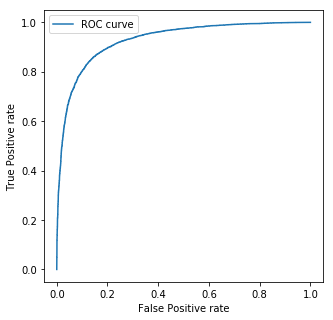

In [101]:
fig, ax = plt.subplots(figsize=(5,5))
cax = ax.plot(roc[0], roc[1], label='ROC curve')
ax.set_xlabel('False Positive rate')
ax.set_ylabel('True Positive rate')
plt.legend()
plt.show()

I predict I will have a ROC score of 0.91